# Preprocessing with voronoi gird

In [5]:
# imports
import numpy as np
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [6]:
# variables
input_file_path = './pickles/st-20231031+wth+elev_filtered.pkl'
input_grid_file_path = './pickles/voronoi-cells.pkl'
output_file_path_prefix = './pickles/gridded_reservations_voronoi'
output_file_path_suffix = '.pickle'

In [7]:
# import reservation data
reservations = pd.read_pickle(input_file_path)
reservations.drop(columns=['reservationId', 'serviceType','preReservationDuration', 'carId', 'customerId', 'drivenDistance', 'usageTime', 'startMileage', 'endMileage', 'cost', 'isCancelled', 'bonusMetersUsed', 'openCallSuccessful', 'openCallSuccessfulTime', 'closeCallSuccessful', 'closeCallSuccessfulTime', 'endRentalCallSuccessful', 'startBatteryLevel', 'endBatteryLevel', 'preReservationCost', 'cancelled', 'endLatUser', 'endLonUser', 'bonusCashUsed', 'created_at', 'updated_at', 'locationId', 'parkTime', 'elevation_start', 'elevation_end', 'chargeLoss', 'timeRented'], inplace=True)
reservations.head()

,startTime,endTime,startLat,startLon,endLat,endLon,start_temp,start_dwpt,start_rhum,start_prcp,...,end_dwpt,end_rhum,end_prcp,end_snow,end_wdir,end_wspd,end_wpgt,end_pres,end_tsun,end_coco
0,2017-10-14 14:15:35,2017-10-14 14:38:17,48.782722,9.181855,48.790642,9.171309,20.8,11.4,55.0,0.0,...,11.4,55.0,0.0,NaN,40.0,5.8,NaN,1026.4,60.0,NaN
1,2017-10-14 14:22:14,2017-10-14 14:51:56,48.771416,9.157480,48.771828,9.156966,20.8,11.4,55.0,0.0,...,11.4,55.0,0.0,NaN,40.0,5.8,NaN,1026.4,60.0,NaN
2,2017-10-14 14:24:42,2017-10-14 14:38:52,48.774971,9.129474,48.778435,9.127503,20.8,11.4,55.0,0.0,...,11.4,55.0,0.0,NaN,40.0,5.8,NaN,1026.4,60.0,NaN
3,2017-10-14 14:25:34,2017-10-14 14:42:13,48.785652,9.159463,48.793102,9.159768,20.8,11.4,55.0,0.0,...,11.4,55.0,0.0,NaN,40.0,5.8,NaN,1026.4,60.0,NaN
4,2017-10-14 14:25:54,2017-10-14 14:44:53,48.784927,9.153793,48.784882,9.206255,20.8,11.4,55.0,0.0,...,11.4,55.0,0.0,NaN,40.0,5.8,NaN,1026.4,60.0,NaN


In [8]:
reservations_grid_input = pd.read_pickle(input_grid_file_path)
reservations_grid_input.columns = ['geometry']
reservations_grid_input

,geometry
0,"POLYGON ((9.20140 48.78842, 9.20179 48.78860, ..."
1,"POLYGON ((9.20164 48.79292, 9.20158 48.79375, ..."
2,"POLYGON ((9.20580 48.78929, 9.20491 48.78855, ..."
3,"POLYGON ((9.20690 48.78794, 9.20778 48.78822, ..."
4,"POLYGON ((9.19428 48.77474, 9.19331 48.77558, ..."
...,...
1145,"POLYGON ((9.19537 48.81084, 9.19541 48.81037, ..."
1146,"POLYGON ((9.23161 48.78640, 9.23470 48.78742, ..."
1147,"POLYGON ((9.22652 48.79181, 9.22483 48.79136, ..."
1148,"POLYGON ((9.21499 48.80062, 9.21484 48.80059, ..."


In [9]:
reservations_grid = gpd.GeoDataFrame(reservations_grid_input, geometry='geometry', crs='EPSG:4326')
reservations_grid

,geometry
0,"POLYGON ((9.20140 48.78842, 9.20179 48.78860, ..."
1,"POLYGON ((9.20164 48.79292, 9.20158 48.79375, ..."
2,"POLYGON ((9.20580 48.78929, 9.20491 48.78855, ..."
3,"POLYGON ((9.20690 48.78794, 9.20778 48.78822, ..."
4,"POLYGON ((9.19428 48.77474, 9.19331 48.77558, ..."
...,...
1145,"POLYGON ((9.19537 48.81084, 9.19541 48.81037, ..."
1146,"POLYGON ((9.23161 48.78640, 9.23470 48.78742, ..."
1147,"POLYGON ((9.22652 48.79181, 9.22483 48.79136, ..."
1148,"POLYGON ((9.21499 48.80062, 9.21484 48.80059, ..."


In [10]:
def map_to_grid(grid, reservation_data):
    # Convert the reservations data to a GeoDataFrame
    reservations_gdf = gpd.GeoDataFrame(reservation_data, geometry=gpd.points_from_xy(reservation_data.startLon, reservation_data.startLat), crs='EPSG:4326')

    # Map the start locations to the grid
    reservations_gdf = reservations_gdf.sjoin(grid, how='left')
    reservations_gdf.rename(columns={'index_right': 'startGridId'}, inplace=True)

    # Map the end locations to the grid
    reservations_gdf.geometry = gpd.points_from_xy(reservations_gdf.endLon, reservations_gdf.endLat)
    reservations_gdf = reservations_gdf.sjoin(grid, how='left')
    reservations_gdf.rename(columns={'index_right': 'endGridId'}, inplace=True)

    return pd.DataFrame(reservations_gdf)

In [11]:
reservations = map_to_grid(reservations_grid, reservations)
reservations.drop(columns=['geometry'], inplace=True)
reservations.head()

,startTime,endTime,startLat,startLon,endLat,endLon,start_temp,start_dwpt,start_rhum,start_prcp,...,end_prcp,end_snow,end_wdir,end_wspd,end_wpgt,end_pres,end_tsun,end_coco,startGridId,endGridId
0,2017-10-14 14:15:35,2017-10-14 14:38:17,48.782722,9.181855,48.790642,9.171309,20.8,11.4,55.0,0.0,...,0.0,NaN,40.0,5.8,NaN,1026.4,60.0,NaN,58.0,107.0
1,2017-10-14 14:22:14,2017-10-14 14:51:56,48.771416,9.157480,48.771828,9.156966,20.8,11.4,55.0,0.0,...,0.0,NaN,40.0,5.8,NaN,1026.4,60.0,NaN,543.0,543.0
2,2017-10-14 14:24:42,2017-10-14 14:38:52,48.774971,9.129474,48.778435,9.127503,20.8,11.4,55.0,0.0,...,0.0,NaN,40.0,5.8,NaN,1026.4,60.0,NaN,781.0,NaN
3,2017-10-14 14:25:34,2017-10-14 14:42:13,48.785652,9.159463,48.793102,9.159768,20.8,11.4,55.0,0.0,...,0.0,NaN,40.0,5.8,NaN,1026.4,60.0,NaN,658.0,NaN
4,2017-10-14 14:25:54,2017-10-14 14:44:53,48.784927,9.153793,48.784882,9.206255,20.8,11.4,55.0,0.0,...,0.0,NaN,40.0,5.8,NaN,1026.4,60.0,NaN,487.0,466.0


In [12]:
# write data to pickles
reservations.to_pickle(output_file_path_prefix + output_file_path_suffix)

In [13]:
def plot_heatmap(grid, reservation_data, column):
    # Count the number of reservations for each grid cell
    counts = reservation_data[column].value_counts()

    # Normalize the counts to the range 0-1
    counts = counts / counts.max()

    # Add the counts to the grid
    grid['count'] = grid.index.map(counts.get).fillna(0)
    
    # Increase the alpha value
    alpha = grid['count'].apply(lambda x: 0 if x == 0 else 0.8)
    
    # Plot the heatmap on top of the basemap
    fig, ax = plt.subplots(1, 1)
    grid = grid.to_crs(epsg=3857)
    grid.plot(column='count', linewidth=1.0, ax=ax, alpha=alpha, cmap='viridis', edgecolor='#002D58')

    # Add the basemap
    ctx.add_basemap(ax, source='OpenStreetMap.Mapnik')

    plt.axis('off')
    plt.show()

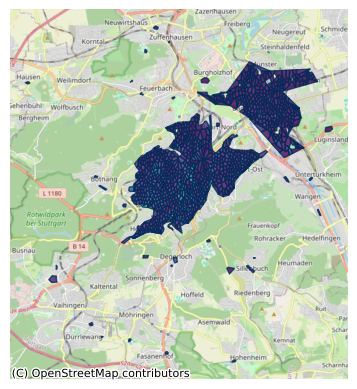

In [14]:
plot_heatmap(reservations_grid, reservations, 'startGridId')

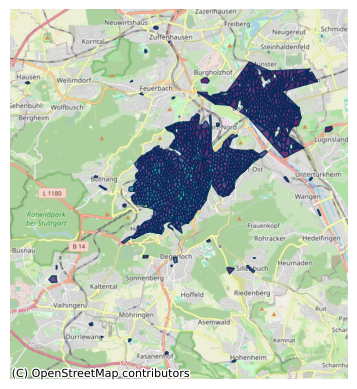

In [15]:
plot_heatmap(reservations_grid, reservations, 'endGridId')